# Run Pharaglow 

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
# image io and analysis
import json
import pims
import trackpy as tp

# plotting
import matplotlib  as mpl 
import matplotlib.pyplot as plt 

#our packages
from pharaglow import tracking, run, features

### Load data and create binary masks 

In [5]:
%%time
# io
fname = "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0014/*.tiff"
parameterfile = "/home/scholz_la/Desktop/pumping/PharaGlow/pharaglow_parameters_mks.txt"
outfile = "/media/scholz_la/hd2/Nicolina/Nicolina/20200109_NZ0014_MKS_{}_{}.json"
lawnfile = '/media/scholz_la/hd2/Nicolina/Nicolina/Lawns/NZ0014_lawn.bmp'
print('Loading parameters from {}'.format(parameterfile.split('/')[-2:]))
with open(parameterfile) as f:
    param = json.load(f)


Loading parameters from ['PharaGlow', 'pharaglow_parameters_mks.txt']
CPU times: user 2.42 ms, sys: 0 ns, total: 2.42 ms
Wall time: 1.39 ms


In [2]:
print('Starting pharaglow analysis...')
rawframes = pims.open(fname)
rawframes = rawframes[:18000]

if lawnfile is not None:
    print('open and binarize lawn file')
    lawn = pims.open(lawnfile)[0]
    binLawn = features.findLawn(lawn)

Starting pharaglow analysis...
Loading parameters from ['PharaGlow', 'pharaglow_parameters_mks.txt']
open and binarize lawn file
CPU times: user 7.72 s, sys: 547 ms, total: 8.26 s
Wall time: 1.72 s


In [ ]:
%%time
# detecting objects
print('Binarizing images')
masks = tracking.calculateMask(rawframes, minSize = param['minSize'], bgWindow = param['bgWindow']
                               , thresholdWindow = param['thresholdWindow'], smooth =  param['smooth'],
                               subtract =  param['subtract'])


### Make sure the thesholding worked otherwise change parameters

In [ ]:
t = 4900
plt.figure(figsize=(18,11))
# plt.subplot(121)
plt.imshow(rawframes[t]+lawn)
# plt.subplot(122)
plt.imshow(masks[t])#[:,2500:])
print(np.sum(masks[t]))#[:,2500:]))

### Detecting individual objects and tracking or use multiprocessing to speed up feature detection

In [ ]:
%%time
import time

nWorkers = 10
if nWorkers ==1:

    #masks = tracking.preprocess(rawframes, minSize = param['minSize'], threshold =None )
    print('Detecting features')
    features = tracking.runfeatureDetection(rawframes, masks, param, frameOffset = 0)
else:
    from multiprocessing import Pool
    print('Detecting features')
    def f(sl):
        a,b = sl
        #print(a,b)
        return tracking.runfeatureDetection(rawframes[a:b], masks[a:b], param, frameOffset = a)
    features = []
    L = len(rawframes)
    # create chunks of analysis based on how many workers we use
    print(L)
    chunksize = L//nWorkers//20
    #slices = np.arange(L)
    slices = zip((range(0,L, chunksize)), (range(chunksize,L+chunksize, chunksize)))
    
    p = Pool(processes = nWorkers)
    start = time.time()
    for k, res in enumerate(p.imap_unordered(f, slices)):
        features.append(res)
        if k == nWorkers:
            print('Expected time is approx. {} s'.format((L/chunksize-k)*(time.time()-start)/nWorkers/2))
        #print(p, time.time()-start)
    features = pd.concat(features)
    p.close()
    p.join()

In [ ]:
### Save the features
plt.plot(np.sort(features['area'].values))

In [ ]:
features.head(5)
features.info(memory_usage='deep')
features.to_json(outfile.format('features', 'all'), orient='split')

In [ ]:
features = pd.read_json(outfile.format('features', 'all'), orient='split', numpy = True)

### Link objects to trajectories and interpolate short misses

In [ ]:
print('Done')
print('Linking trajectories')
#trajectories = tracking.linkParticles(features, param['searchRange'], param['minimalDuration'])
#trajectories = tracking.linkParticles(features, 50, 500);
#trajectories = tp.link_df(features, 50, memory= 30)
#trajectories = tp.filter_stubs(trajectories,100)
pred = tp.predict.NearestVelocityPredict()
trajectories = pred.link_df(features, 30, memory= 30)

In [ ]:
print('Interpolating trajectories')
traj = []
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    traj.append(tracking.interpolateTrajectories(tmp))
trajectories = pd.concat(traj)

In [ ]:
print(trajectories['particle'].nunique())
trajectories = tp.filter_stubs(trajectories,600)
print(trajectories['particle'].nunique())

### Save / Load trajectories if you need to have a checkpoint

In [ ]:
trajectories.to_json(outfile.format('trajectories', 'all'), orient='split')

In [ ]:
trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
trajectories['image'].replace('None', np.nan, inplace=True)

In [ ]:
trajectories['image'].replace([None], np.nan, inplace=True)

### add the missing images to interpolated trajectories

In [ ]:
%%time
print('Fill in missing images')
from pharaglow import tracking, run, features
trajectories[['image']] = trajectories.apply(\
        lambda row: pd.Series(tracking.fillMissingImages(rawframes, row['frame'], row['x'], row['y'],\
                                                length=param['length'], size=param['watershed'])) if np.all(np.isnan(row['image'])) else row['image'], axis=1)

In [ ]:
%xdel rawframes 

### Extract lawn info

In [ ]:
%%time

def inside(x,y,binLawn):
    return binLawn[int(y), int(x)]

if lawnfile is not None:
    trajectories['inside'] = trajectories.apply(\
        lambda row: pd.Series(inside(row['x'], row['y'], binLawn)), axis=1)

### Show resulting trajectories

In [ ]:
plt.figure(figsize=(11,11))
tp.plot_traj(trajectories, superimpose=1-masks[17000]);

### write trajectories to file

In [ ]:
# # write trajectories to separate files.
#trajectories = pd.read_json(outfile.format('trajectories', 'all'), orient='split', numpy = True)
for particle_index in trajectories['particle'].unique():
    tmp = trajectories[trajectories.loc[:,'particle'] == particle_index]
    tmp.to_json(outfile.format('trajectories', particle_index), orient='split')

### check slow-down before continuing analysis

In [ ]:
plt.figure(figsize=(12,8))
vcut = []
dt = 500
for pid in trajectories['particle'].unique():
    tmp = trajectories[['frame', 'x', 'y']][trajectories.loc[:,'particle'] == pid].diff()
    f = (trajectories[['inside']][trajectories.loc[:,'particle'] == pid]).mean().values
    if f<0.9 and f>0.01:
        t0 = np.where((trajectories[['inside']][trajectories.loc[:,'particle'] == pid])==1)[0][0]
        if t0>dt:
            time = np.linspace(0,2*dt/30., 2*dt)
            v = np.sqrt((tmp['x']**2+tmp['y']**2))/tmp['frame']*30*2.4
            plt.plot(time, v.iloc[t0-dt:t0+dt].values, 'navy', alpha=0.1)
            vcut.append(v.iloc[t0-dt:t0+dt].values)
plt.plot(time, np.mean(np.array(vcut), axis=0), color='navy')
plt.axvline(dt/30, color='k', linestyle='--')
plt.ylabel(r"velocity ($\mu$m/s)");
plt.xlabel("time (s)");


### run the whole pharaglow feature extraction

In [3]:
from multiprocessing import Pool
def parallelize_dataframe(df, func, params, n_cores):
    df_split = np.array_split(df, n_cores//5)
    print([len(d) for d in df_split])
    pool = Pool(n_cores)
    df = pd.concat(pool.starmap(func, zip(df_split, np.repeat(params, len(df_split)))))
    pool.close()
    pool.join()
    return df

### Save data as hdf5 format (every trajectory in a file)

In [ ]:
%%time
import os
path = os.path.dirname(outfile)
for fn in os.listdir(path):
    file =os.path.join(path,fn)
    if os.path.isfile(file) and 'trajectories_' in fn and fn.endswith('.json'):
        particle_index = int(fn.split('.')[0].split('_')[-1])
        if particle_index <19:
            continue
        traj =  pd.read_json(file, orient='split', numpy = True)
        print('Analyzing trajectory:', fn)
        try:
            tmp = parallelize_dataframe(traj, run.runPharaglowOnStack, n_cores = 5, params = param)
            tmp.to_json(outfile.format('results', particle_index), orient='split')
        except ValueError:
            continue

Analyzing trajectory: 20200109_NZ0014_MKS_trajectories_102.json
[281, 281, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280, 280]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/opt

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200109_NZ0014_MKS_trajectories_114.json
[92, 92, 92, 92, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 171 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 225 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 179 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 223 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 249 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200109_NZ0014_MKS_trajectories_115.json
[92, 92, 92, 92, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91, 91]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 217 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 208 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 183 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 201 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 191 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 197 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 169 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 196 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 176 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 180 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 199 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 166 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200109_NZ0014_MKS_trajectories_19.json
[279, 279, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 185 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 206 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 207 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 202 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 209 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 220 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 203 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 245 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 205 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 231 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 240 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 215 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 252 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 200 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 236 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 181 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 190 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200109_NZ0014_MKS_trajectories_20.json
[279, 279, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278, 278]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWar

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 242 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 238 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 187 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 228 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 235 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 244 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 239 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 243 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 241 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 219 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 214 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 216 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 210 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 229 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 204 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 198 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 184 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 186 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 188 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 211 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 178 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

Analyzing trajectory: 20200109_NZ0014_MKS_trajectories_29.json
[800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 800, 799]


/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/scikit-image/skimage/filters/thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))
/home/scholz_la/.conda/envs/pumping/lib/python3.7/site-packages/scipy/optimize/minpack.py:799: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/scholz_

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 254 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 253 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 248 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 247 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 251 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 250 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 246 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 194 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 195 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 189 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 213 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 218 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 226 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 232 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 222 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 233 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/s

/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 227 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 224 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 221 fits in uint8
  return convert(image, np.uint8, force_copy)
/home/scholz_la/scikit-image/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 230 fits in uint8
  return convert(image, np.uint8, force_copy)


In [7]:
file =os.path.join(path,fn)

'20200109_NZ0014_MKS_trajectories_19.json'

In [9]:
traj =  pd.read_json(file, orient='split', numpy = True)

In [ ]:
plt.imshow(np.array(traj['image'].loc[7333]).reshape((100,100)))

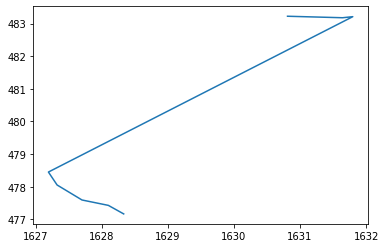

In [37]:
plt.plot(traj['x'].loc[7330:7360], traj['y'].loc[7330:7360])